In [1]:
import numpy as np
from sklearn import datasets, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from neupy import algorithms
import pandas as pd
from scipy.optimize import basinhopping

# GRNN for all three output variables

In [15]:
class GRNN():
    def __init__(self, nn, scaler_x, scaler_y):
        self.nn = nn
        self.scaler_x = scaler_x
        self.scaler_y = scaler_y

def fit(X_, Y_):
    grnns = []
    for i in range(Y_.shape[1]):
        scaler_x = MinMaxScaler(feature_range=(0, 1))
        scaler_y = MinMaxScaler(feature_range=(0, 1))
        
        X = scaler_x.fit_transform(X_)
        Y = scaler_y.fit_transform(np.expand_dims(Y_[:, i], -1))

        x_train = X[:, :]
        x_test = X[120:, :]
        y_train = np.expand_dims(Y[:, :], -1)
        y_test = np.expand_dims(Y[120:, :], -1)
        nw = algorithms.GRNN(std=0.05, verbose=False)
        nw.train(x_train, y_train)
        
        grnns.append(GRNN(nw, scaler_x, scaler_y))
    return grnns

def calculate_error(grnns, X_, Y_):
    mses = []
    preds = []
    for i, grnn in enumerate(grnns):
        X = grnn.scaler_x.transform(X_)
        pred = grnn.nn.predict(X)
        pred= np.squeeze(pred, -1)
        pred = grnn.scaler_y.inverse_transform(pred)
        preds.append(pred)
        mse = np.mean((np.expand_dims(Y_[:, i], -1) - pred) ** 2)
        mses.append(mse)
    return mses, np.concatenate(preds, 1)


X_ = pd.read_csv(r'C:\Users\Saravanan\Desktop\maybe\paper work\syncrel\x_2.csv', header = None).values#[:, :]
Y_ = pd.read_csv(r'C:\Users\Saravanan\Desktop\maybe\paper work\syncrel\y_2.csv', header = None).values#[:, 0]

grnns = fit(X_, Y_)
x_test = X_[120:, :]
y_test = Y_[120:, :]
mses, preds = calculate_error(grnns, x_test, y_test)

# print(np.concatenate([y_test, preds], 1))

for mse in mses:
    print(mse)

1.9818776482960844e-06
2.3258826086422893e-05
3.191639546869193e-06


# Trial 3 - Based on doc from github - uses unscaled cost function

In [35]:
class Objective(object):
    def __init__(self, grnns, xmin, xmax):
        self.grnns = grnns
        self.xmin = xmin
        self.xmax = xmax
    
    def __call__(self, X): # simple addition
        if not (np.all(X <= self.xmax) and np.all(X >= self.xmin)):
            return 10000
        tripple = 0
        eff = 1
        tav = 2
        value = 0
        X = np.expand_dims(X, 0)
        for i, grnn in enumerate(self.grnns):
            x_scaled = grnn.scaler_x.transform(X)
            pred = grnn.nn.predict(x_scaled)
            pred = np.squeeze(pred, -1)
            pred = grnn.scaler_y.inverse_transform(pred)
            if i == tav: # increase
                value += 100 - (((pred-7.3135) / (9.0753-7.3135)) * 100)
            elif i == eff: # increase
                value += 100 - (((pred-90.0915) / (91.5237-90.0915)) * 100)
            elif i == tripple: # decrease
                value += (((pred-0.0793) / (0.2759-0.0793)) * 100)
        return value[0][0]

class MyBounds(object):
    def __init__(self, xmax, xmin):
        self.xmax = np.array(xmax)
        self.xmin = np.array(xmin)
    def __call__(self, **kwargs):
        x = kwargs["x_new"]
        tmax = bool(np.all(x <= self.xmax))
        tmin = bool(np.all(x >= self.xmin))
        return tmax and tmin
    
class MyTakeStep(object):
    def __init__(self,xmin, xmax, stepsize=0.02):
#         self.stepsize = stepsize
        self.xmin = np.array(xmin)
        self.xmax = np.array(xmax)
        self.stepsize = (self.xmax - self.xmin) * 0.2
    def __call__(self, x):
        s = self.stepsize
        x += np.random.uniform(-s, s)
#         x[:-1] += np.random.uniform(-s, s)
#         x[-1] += np.random.uniform(-0.01, 0.01, x[-1].shape)
        return x
    
df = pd.DataFrame(columns = ['f', 'accepted', 'x'])

def print_fun(x, f, accepted):
    global df
#     if accepted == 1:
#         print("at minimum %.4f accepted %d" % (f, int(accepted)))
#     if f < 10000:
#         print("at minimum %.4f accepted %d" % (f, int(accepted)))
#     print("at minimum %.4f accepted %d" % (f, int(accepted)))
    df = df.append(pd.DataFrame([[f, accepted, x]], columns = ['f', 'accepted', 'x']))


xmin=[2.985700615, 4.1556724, 5.20306143, 2.6, 1.458841307, 1.247463957, 10.7643, 24.5952, 36.6826, 0.45, 2, 3, 5]
xmax=[3.994173672, 5.229702309, 6.362200008, 6.528583919, 3.133207987, 2.437445577, 13.3, 25.7294, 38.85875, 0.55, 3.396079904, 5.990883651, 9.356113776]

mybounds = MyBounds(xmin=xmin, xmax=xmax)

mytakestep = MyTakeStep(xmin=xmin, xmax=xmax)

func = Objective(grnns, xmin, xmax)

# x0 = [3.994173672, 5.229702309, 6.362200008, 6.528583919, 3.133207987, 2.437445577, 10.7643, 24.5952, 37.8805, 0.45, 2.754129886, 5.10186292, 7.785400158]
x0 = [3.045500896, 4.155738609, 5.291409415, 3.401172985, 1.754293289, 1.441615018, 12.2006, 25.17835, 38.2763, 0.45, 2, 3, 5]
# x0 = xmax
# x0 = [np.random.uniform(l, h) for l, h in zip(xmin, xmax)]
# minimizer_kwargs = {"method": "BFGS"}
minimizer_kwargs = {"method":"L-BFGS-B"}

print(x0)
ret = basinhopping(func, x0, minimizer_kwargs=minimizer_kwargs, niter=1000, take_step=mytakestep,
                   accept_test=mybounds, callback=print_fun)
print(df.shape)

[3.045500896, 4.155738609, 5.291409415, 3.401172985, 1.754293289, 1.441615018, 12.2006, 25.17835, 38.2763, 0.45, 2, 3, 5]
(1000, 3)


In [36]:
%matplotlib notebook
accepted_df = df[df['accepted'] == True]
accepted_df
# df

,f,accepted,x
0,165.18,True,"[3.1525226492138527, 4.320061575042693, 5.4154..."
0,127.595,True,"[3.174551619266084, 4.341074564476494, 5.54108..."
0,127.65,True,"[3.0037963297670154, 4.475011657129271, 5.5551..."
0,127.785,True,"[3.0897054792030074, 4.629615562456755, 5.5306..."
0,127.845,True,"[3.2148808745569797, 4.520205058659258, 5.6254..."
...,...,...,...
0,98.5885,True,"[3.8303541963440453, 4.2622581868549245, 5.439..."
0,98.5885,True,"[3.9131735143795905, 4.3097804291163495, 5.527..."
0,98.5885,True,"[3.9365053105712495, 4.28930194411738, 5.57440..."
0,98.5885,True,"[3.923853638465796, 4.229420897601608, 5.60688..."


<IPython.core.display.Javascript object>


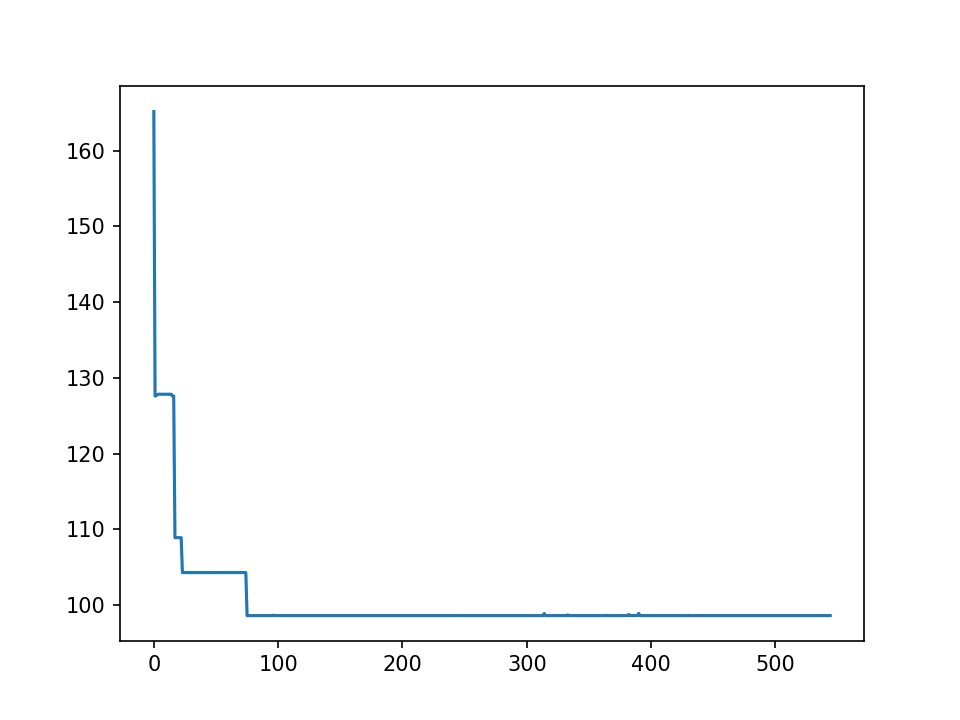

In [41]:
import matplotlib.pyplot as plt
plt.plot(list(range(accepted_df.shape[0])), accepted_df['f'])
# plt.plot(list(range(df.shape[0])), df['f'])

In [38]:
import datetime

x = datetime.datetime.now()
# 'basin_hopping_{:02.0f}{:02.0f}_{:02.0f}{:02.0f}{:02.0f}.csv'.format(x.date, x.month, x.hour, x.minute. x.second)
df.to_csv('basin_hopping_result_4.csv')
# x.strftime("%A, %d. %B %Y %I:%M%p")

In [4]:
def predict(grnns, X):
    tav = 0
    eff = 1
    tripple = 2
    X = np.expand_dims(X, 0)
    for i, grnn in enumerate(grnns):
        x_scaled = grnn.scaler_x.transform(X)
        pred = grnn.nn.predict(x_scaled)
        pred = np.squeeze(pred, -1)
        if i == tav:
            print('Tav', grnn.scaler_y.inverse_transform(pred)[0][0])
        elif i == eff:
            print('eff', grnn.scaler_y.inverse_transform(pred)[0][0])
        elif i == tripple:
            print('tripple', grnn.scaler_y.inverse_transform(pred)[0][0])

predict(grnns, [2.98798225, 4.5117677, 5.34903877, 3.4764342, 2.05641709, 1.2660839,
                12.5082, 25.24901176, 38.41261319, 0.47293254])

7.943545143111808
0.8925008031016674
8.104112858295105
